# Data loading and preparation

### Imports

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [92]:
# load the dataset
df = pd.read_csv("../data/movies_combined_inflated.csv")

df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,...,combined_revenue,release_month,release_day,primaryTitle,startYear,averageRating,numVotes,tconst,director,inflated_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...",2001.0,...,14010832.0,8.0,24.0,Ghosts of Mars,2001.0,4.9,58868.0,tt0228333,John Carpenter,1.899115e+07
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...",1938.0,...,4000000.0,8.0,16.0,Alexander's Ragtime Band,1938.0,6.8,2357.0,tt0029852,Henry King,6.812740e+07
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"[('/m/02h40lc', 'English Language')]","[('/m/07ssc', 'United Kingdom')]","[('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...",1989.0,...,10161099.0,11.0,8.0,Henry V,1989.0,7.5,32088.0,tt0097499,Kenneth Branagh,1.967252e+07
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/0hj3myq', ""Children's/Family""), ('/m/04t...",1964.0,...,102272727.0,8.0,27.0,Mary Poppins,1964.0,7.8,189183.0,tt0058331,Robert Stevenson,7.913870e+08
4,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...",1999.0,...,21521.0,10.0,1.0,NaN,NaN,0.0,0.0,NaN,Unknown,3.100822e+04


### Defining seasons

In [93]:
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return np.nan  # Handle missing or invalid months

df['release_month'] = pd.to_datetime(df['movie_release_date'], errors='coerce').dt.month
df['season'] = df['release_month'].apply(assign_season)


### Checking for missing values and handling

In [94]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing revenue or runtime
df = df.dropna(subset=['movie_box_office_revenue', 'movie_runtime'])


wiki_movie_id                  0
freebase_movie_id              0
movie_name                     0
movie_release_date             0
movie_box_office_revenue    1237
movie_runtime                185
movie_languages                0
movie_countries                0
movie_genres                   0
release_year                   0
title                       1636
revenue                     4450
budget                      5110
imdb_id                     1636
combined_revenue               0
release_month                  0
release_day                    0
primaryTitle                1636
startYear                   1636
averageRating                  0
numVotes                       0
tconst                      1636
director                       0
inflated_revenue               0
season                         0
dtype: int64


### Ensuring numeric input

In [95]:
df['movie_box_office_revenue'] = pd.to_numeric(df['movie_box_office_revenue'])
df['movie_runtime'] = pd.to_numeric(df['movie_runtime'])


# Analysis

Histogram showing how movie revenues are distributed across all movies

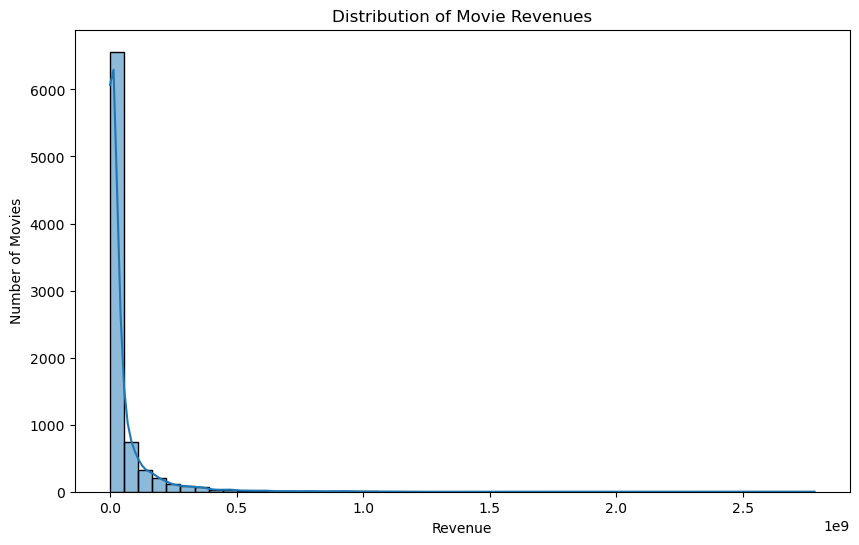

In [96]:
plt.figure(figsize=(10, 6))
sns.histplot(df['movie_box_office_revenue'], bins=50, kde=True)
plt.title('Distribution of Movie Revenues')
plt.xlabel('Revenue')
plt.ylabel('Number of Movies')
plt.show()


Bar plot comparing the average revenue of movies released in different seasons

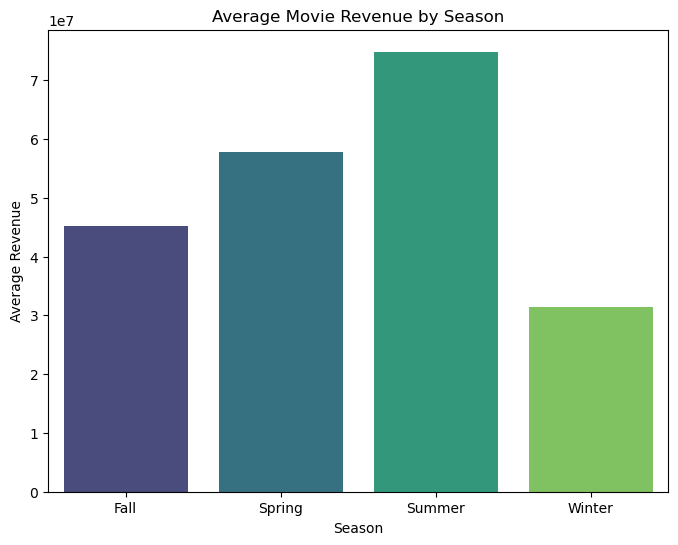

In [97]:
season_revenue = df.groupby('season')['movie_box_office_revenue'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='season', y='movie_box_office_revenue', data=season_revenue, palette='viridis')
plt.title('Average Movie Revenue by Season')
plt.xlabel('Season')
plt.ylabel('Average Revenue')
plt.show()


Scatter plot showing the relationship between movie duration and revenue, with points colored by season

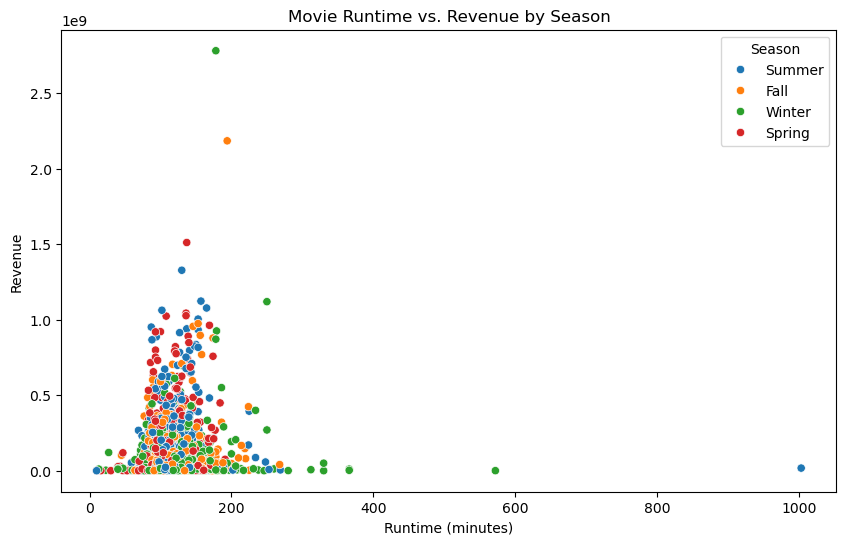

In [98]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='movie_runtime', y='movie_box_office_revenue', hue='season', data=df)
plt.title('Movie Runtime vs. Revenue by Season')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Revenue')
plt.legend(title='Season')
plt.show()


### Genre analysis

Top 10 genres by revenue

In [99]:
import ast

# Convert the string representation to an actual list
df_genres = df.copy()

# First, ensure that the 'movie_genres' column is not null
df_genres = df_genres[df_genres['movie_genres'].notna()]

# Apply ast.literal_eval to convert strings to lists
df_genres['movie_genres'] = df_genres['movie_genres'].apply(ast.literal_eval)

# Now extract the genre names
df_genres['movie_genres'] = df_genres['movie_genres'].apply(lambda x: [genre[1] for genre in x])

# Explode the genres
df_genres = df_genres.explode('movie_genres')


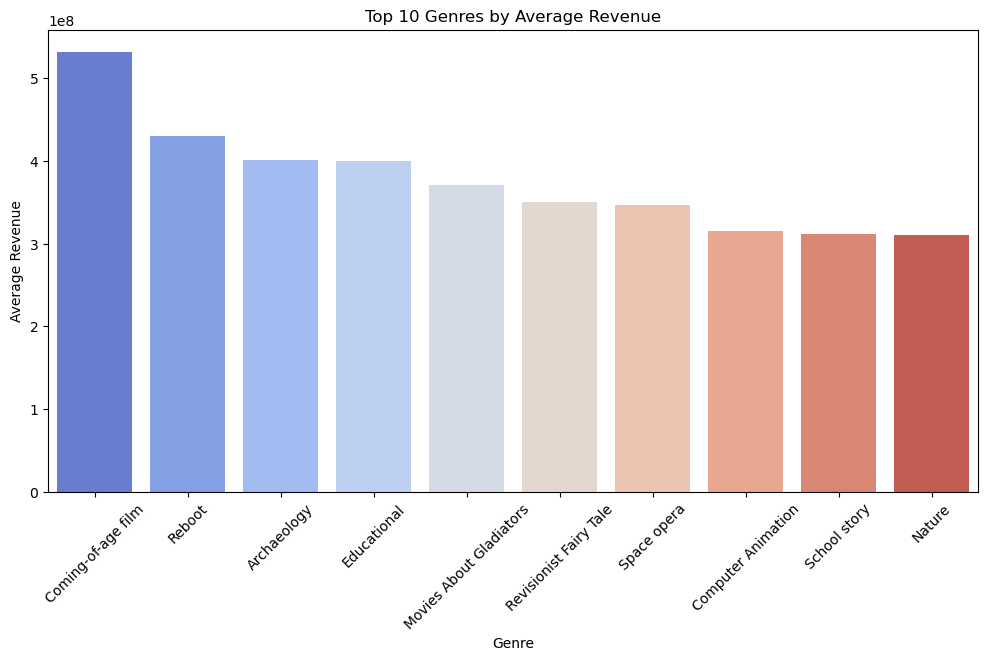

In [100]:
genre_revenue = df_genres.groupby('movie_genres')['movie_box_office_revenue'].mean().reset_index()
top_genres = genre_revenue.sort_values('movie_box_office_revenue', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='movie_genres', y='movie_box_office_revenue', data=top_genres, palette='coolwarm')
plt.title('Top 10 Genres by Average Revenue')
plt.xlabel('Genre')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.show()


Revenue based on season and genre

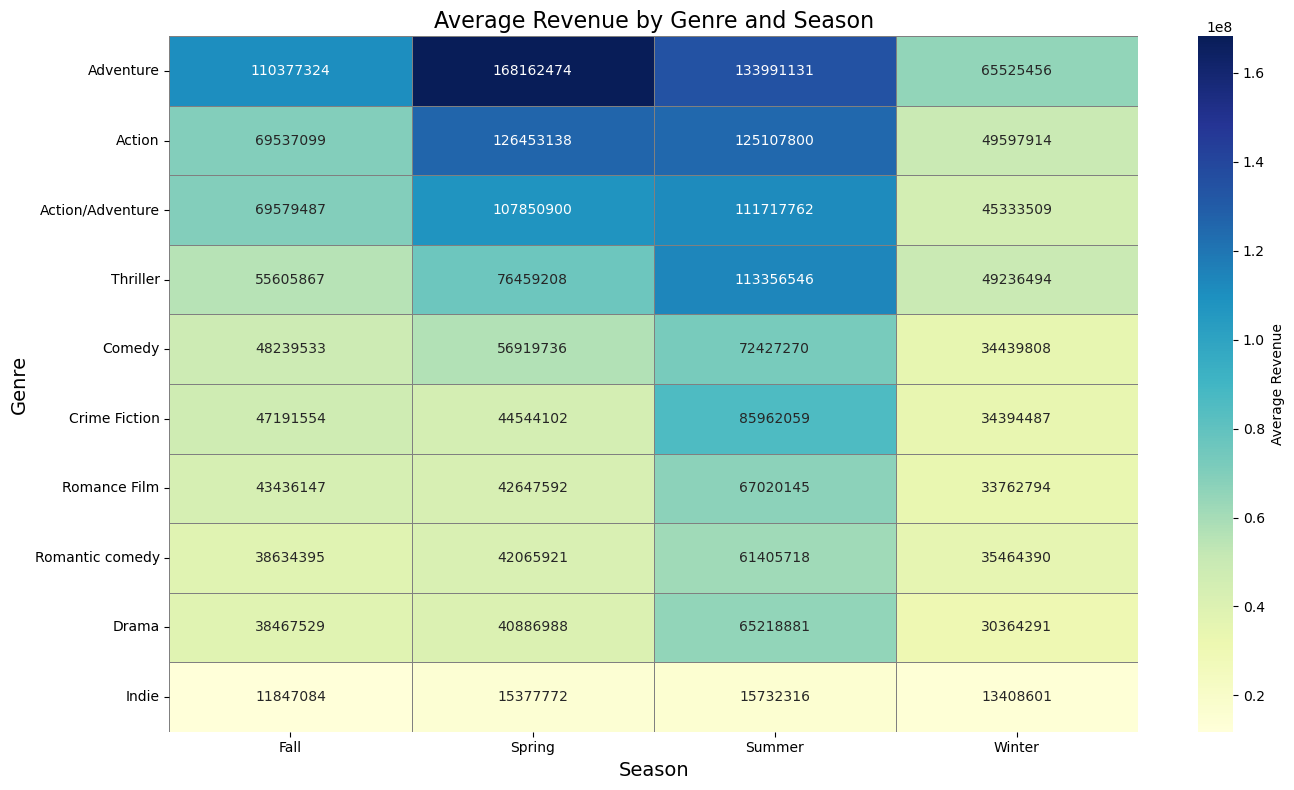

In [101]:
import ast

# Convert string representation to actual list
df_genres = df.copy()
df_genres['movie_genres'] = df_genres['movie_genres'].apply(ast.literal_eval)
df_genres['movie_genres'] = df_genres['movie_genres'].apply(lambda x: [genre[1] for genre in x])
df_genres = df_genres.explode('movie_genres')

# Get top 10 genres by frequency
top_genres_list = df_genres['movie_genres'].value_counts().head(10).index.tolist()
df_top_genres = df_genres[df_genres['movie_genres'].isin(top_genres_list)]

pivot_table = df_top_genres.pivot_table(
    values='movie_box_office_revenue',
    index='movie_genres',
    columns='season',
    aggfunc='mean'
)

# Calculate average revenue per genre
genre_revenue = df_top_genres.groupby('movie_genres')['movie_box_office_revenue'].mean().reset_index()
sorted_genres = genre_revenue.sort_values('movie_box_office_revenue', ascending=False)['movie_genres']

# Reorder the pivot table
pivot_table = pivot_table.reindex(index=sorted_genres)

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".0f",
    cmap='YlGnBu',
    linewidths=.5,
    linecolor='gray',
    cbar_kws={'label': 'Average Revenue'}
)
plt.title('Average Revenue by Genre and Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.yticks(rotation=0)  # Keep genre labels horizontal
plt.xticks(rotation=0)  # Keep season labels horizontal
plt.tight_layout()
plt.show()



Alternative representation 1

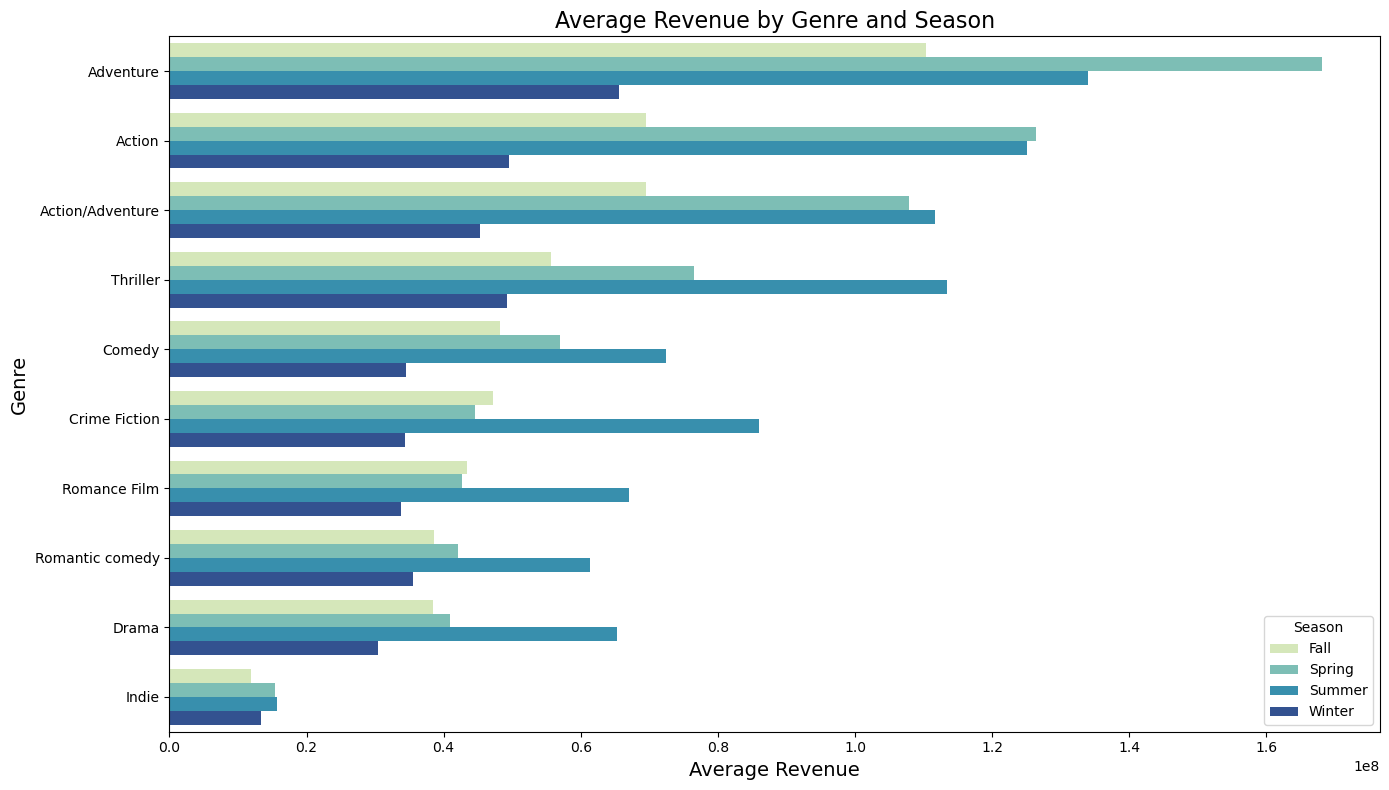

In [102]:
# Reset index for plotting
pivot_table_reset = pivot_table.reset_index().melt(id_vars='movie_genres', var_name='Season', value_name='Average Revenue')

plt.figure(figsize=(14, 8))
sns.barplot(
    x='Average Revenue',
    y='movie_genres',
    hue='Season',
    data=pivot_table_reset,
    palette='YlGnBu'
)
plt.title('Average Revenue by Genre and Season', fontsize=16)
plt.xlabel('Average Revenue', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.legend(title='Season')
plt.tight_layout()
plt.show()


Alternative representation 2

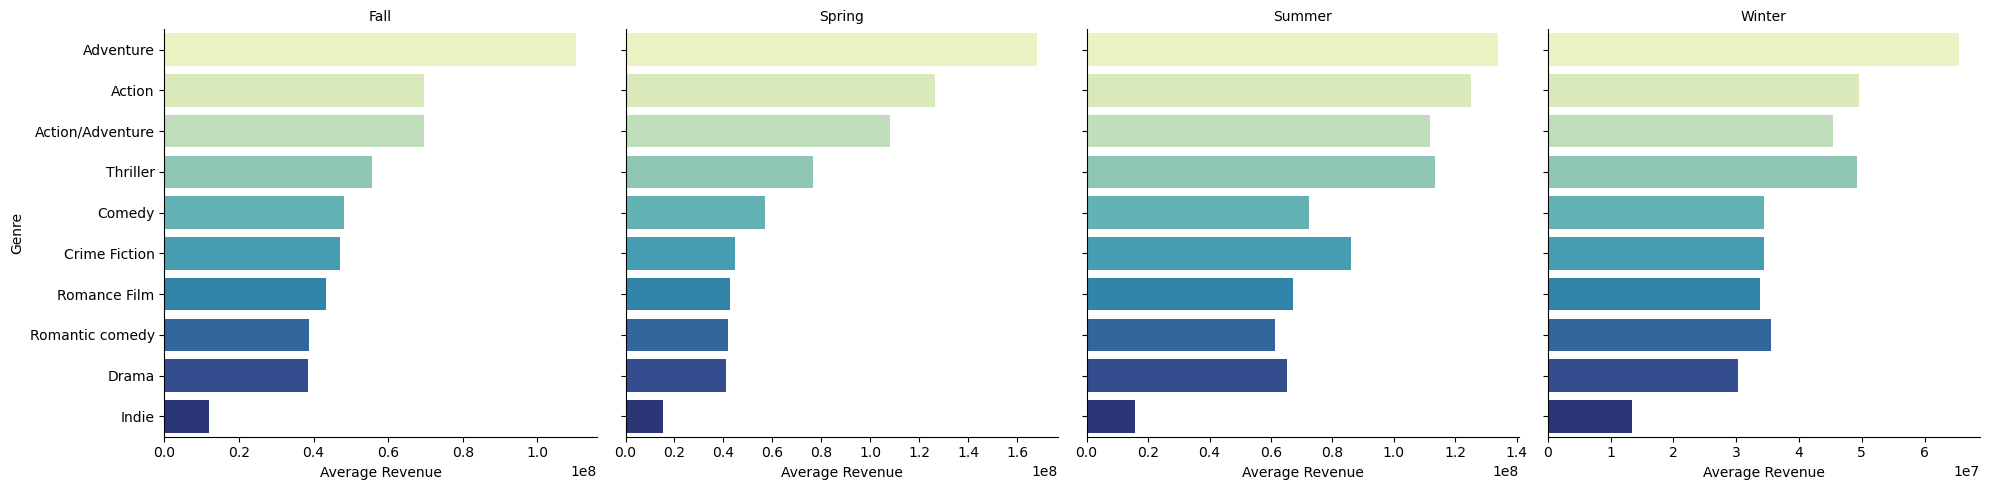

In [103]:
g = sns.FacetGrid(
    pivot_table_reset,
    col="Season",
    sharex=False,
    sharey=True,
    height=5,
    aspect=1
)
g.map_dataframe(
    sns.barplot,
    x='Average Revenue',
    y='movie_genres',
    order=sorted_genres,
    palette='YlGnBu'
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Revenue", "Genre")
g.set(yticks=sorted_genres)
plt.tight_layout()
plt.show()


Alternative representation 3, disregarding thee frequency

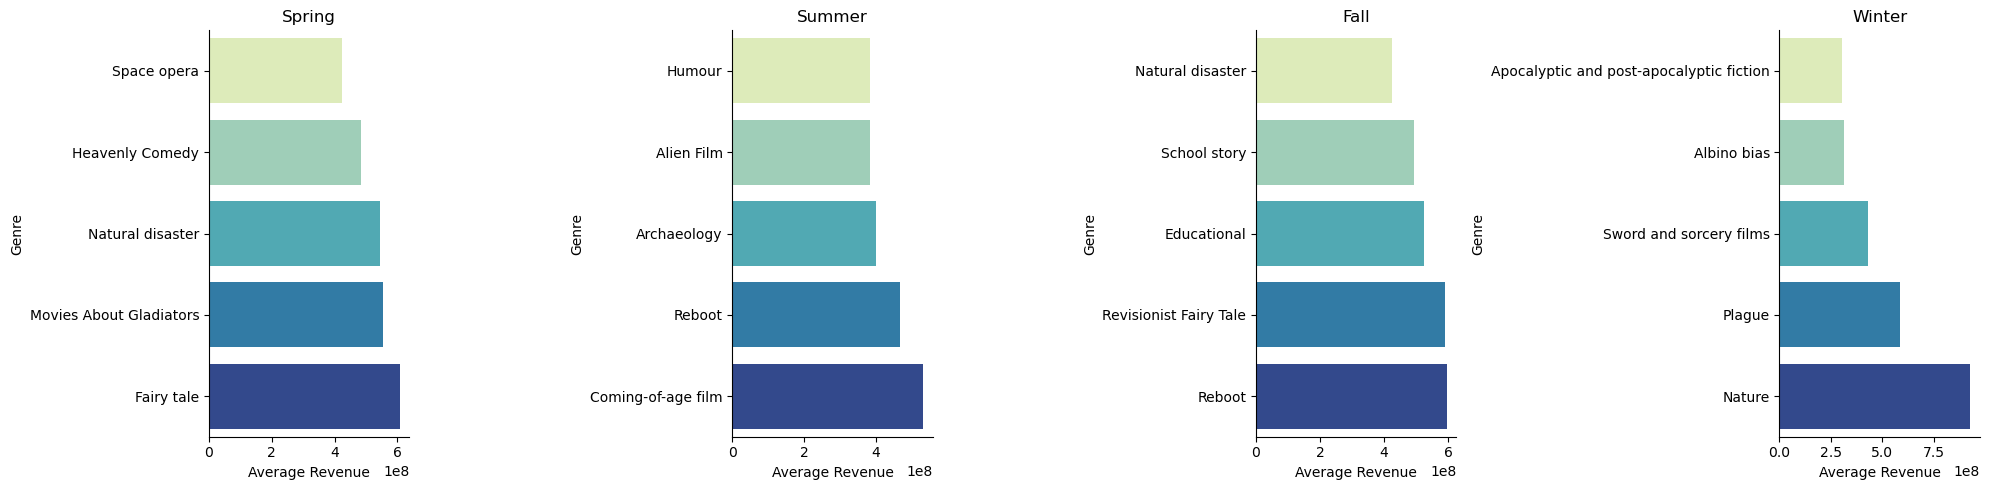

In [104]:
# Drop rows with missing values in 'season' or 'movie_box_office_revenue'
df_genres_season = df_genres.dropna(subset=['season', 'movie_box_office_revenue'])

# Calculate average revenue per genre per season
genre_season_revenue = df_genres_season.groupby(['season', 'movie_genres'])['movie_box_office_revenue'].mean().reset_index()

# Number of top genres to display per season
top_n = 5  # Adjust this number as needed

# Dictionary to store top genres per season
top_genres_per_season = {}

for season in genre_season_revenue['season'].unique():
    top_genres = (
        genre_season_revenue[genre_season_revenue['season'] == season]
        .sort_values('movie_box_office_revenue', ascending=False)
        .head(top_n)['movie_genres']
        .tolist()
    )
    top_genres_per_season[season] = top_genres

# Initialize an empty DataFrame to store filtered data
filtered_genre_season_revenue = pd.DataFrame()

# Loop through each season and filter the top genres
for season in top_genres_per_season:
    top_genres = top_genres_per_season[season]
    temp_df = genre_season_revenue[
        (genre_season_revenue['season'] == season) &
        (genre_season_revenue['movie_genres'].isin(top_genres))
    ]
    filtered_genre_season_revenue = pd.concat([filtered_genre_season_revenue, temp_df], ignore_index=True)

# Rename columns for clarity
filtered_genre_season_revenue.rename(
    columns={
        'movie_genres': 'Genre',
        'movie_box_office_revenue': 'Average Revenue',
        'season': 'Season'
    },
    inplace=True
)

# Set the order of seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Create the FacetGrid
g = sns.FacetGrid(
    filtered_genre_season_revenue,
    col="Season",
    col_order=season_order,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1
)

# Map the barplot onto the FacetGrid
g.map_dataframe(
    sns.barplot,
    x='Average Revenue',
    y='Genre',
    palette='YlGnBu'
)

# Adjust titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Revenue", "Genre")

# Adjust y-ticks and sort data within each subplot
for ax, season in zip(g.axes.flat, season_order):
    # Get top genres for this season
    top_genres = top_genres_per_season.get(season, [])
    # Reverse the order for better visualization
    top_genres_reversed = list(reversed(top_genres))
    # Filter data for the current season
    data = filtered_genre_season_revenue[filtered_genre_season_revenue['Season'] == season]
    # Sort data according to top genres
    data = data.set_index('Genre').loc[top_genres_reversed].reset_index()
    # Clear the axis and plot again
    ax.clear()
    sns.barplot(
        x='Average Revenue',
        y='Genre',
        data=data,
        palette='YlGnBu',
        ax=ax
    )
    ax.set_title(season)
    ax.set_xlabel('Average Revenue')
    ax.set_ylabel('Genre')

plt.tight_layout()
plt.show()


Revenue vs. Duration by Season

<Figure size 1000x600 with 0 Axes>

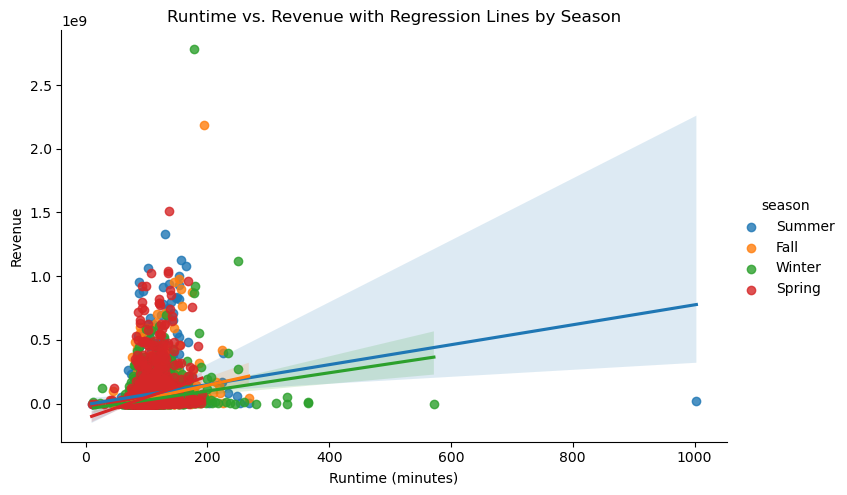

In [105]:
plt.figure(figsize=(10, 6))
sns.lmplot(x='movie_runtime', y='movie_box_office_revenue', hue='season', data=df, aspect=1.5)
plt.title('Runtime vs. Revenue with Regression Lines by Season')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Revenue')
plt.show()


The scatter plot shows the relationship between the movie runtime and the box office revenue, where the movies are categorized by the season in which they were released.
Regression lines are added for each season, showing the trend or slope for each season’s data points. The lines indicate if there is a positive, negative, or negligible correlation between runtime and revenue for each season.

Positive Slope: Implies that movies with longer runtimes tend to generate higher revenue in that season.

Negative Slope: Suggests that shorter movies tend to have higher revenue in that season.

Flat or Near-Zero Slope: Indicates little to no relationship between runtime and revenue for that season.

Movie revenue by the day of the week

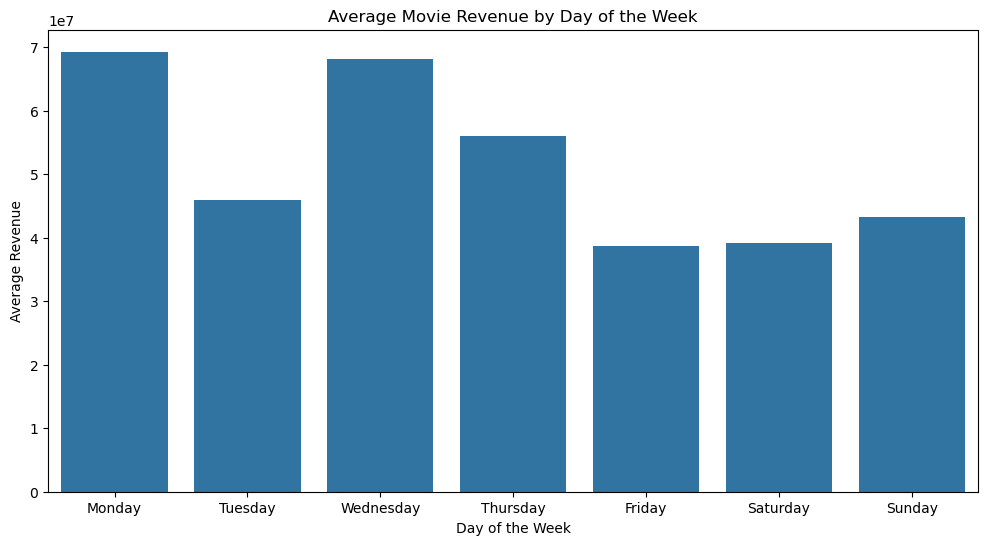

In [106]:
# Convert release date to datetime
df['movie_release_date'] = pd.to_datetime(df['movie_release_date'], errors='coerce')

# Extract day of the week
df['release_dayofweek'] = df['movie_release_date'].dt.day_name()

day_revenue = df.groupby('release_dayofweek')['movie_box_office_revenue'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.barplot(x='release_dayofweek', y='movie_box_office_revenue', data=day_revenue, order=day_order)
plt.title('Average Movie Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Revenue')
plt.show()


Heatmap of Genre Frequency by Year

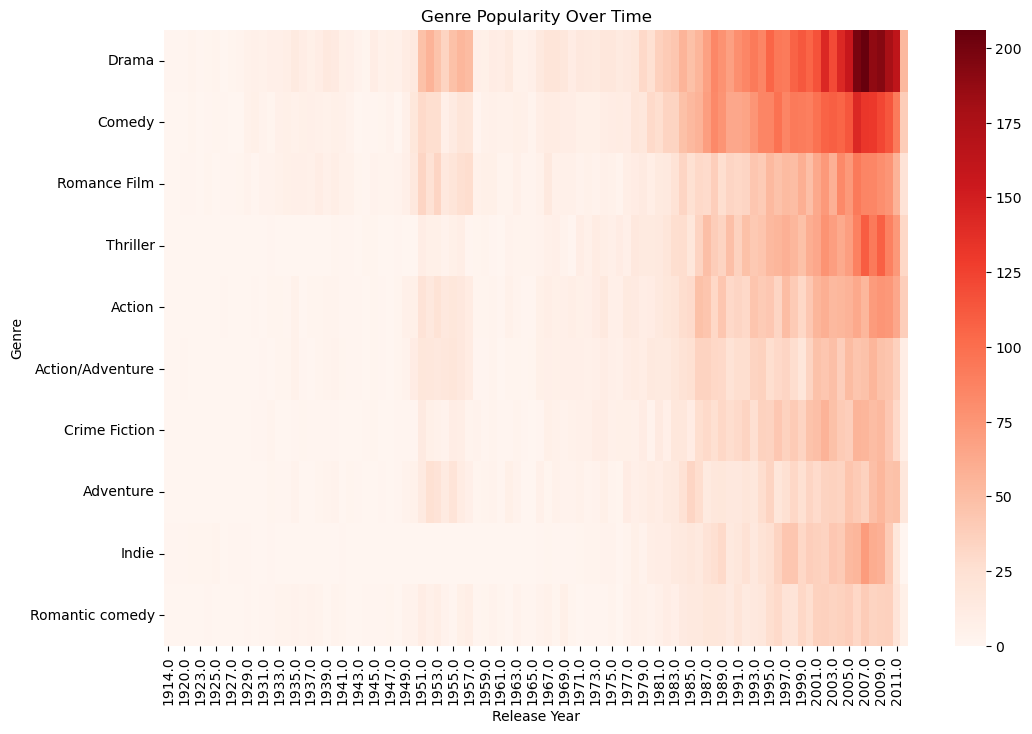

In [107]:
# Count of genres per year
genre_year = df_genres.groupby(['movie_genres', 'release_year']).size().reset_index(name='count')

# Pivot table
genre_year_pivot = genre_year.pivot_table(values='count', index='movie_genres', columns='release_year', fill_value=0)

# Select top genres
top_genres_list = df_genres['movie_genres'].value_counts().head(10).index.tolist()
genre_year_pivot = genre_year_pivot.loc[top_genres_list]

plt.figure(figsize=(12, 8))
sns.heatmap(genre_year_pivot, cmap='Reds')
plt.title('Genre Popularity Over Time')
plt.xlabel('Release Year')
plt.ylabel('Genre')
plt.show()


Genre popularity by season

/var/folders/fl/j46d182j125ctdmkv49vt3y40000gn/T/ipykernel_51867/3237888999.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
/var/folders/fl/j46d182j125ctdmkv49vt3y40000gn/T/ipykernel_51867/3237888999.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
/var/folders/fl/j46d182j125ctdmkv49vt3y40000gn/T/ipykernel_51867/3237888999.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
/var/folders/fl/j46d182j125ctdmkv49vt3y40000gn/T/ipykernel_51867/3237888999.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixed

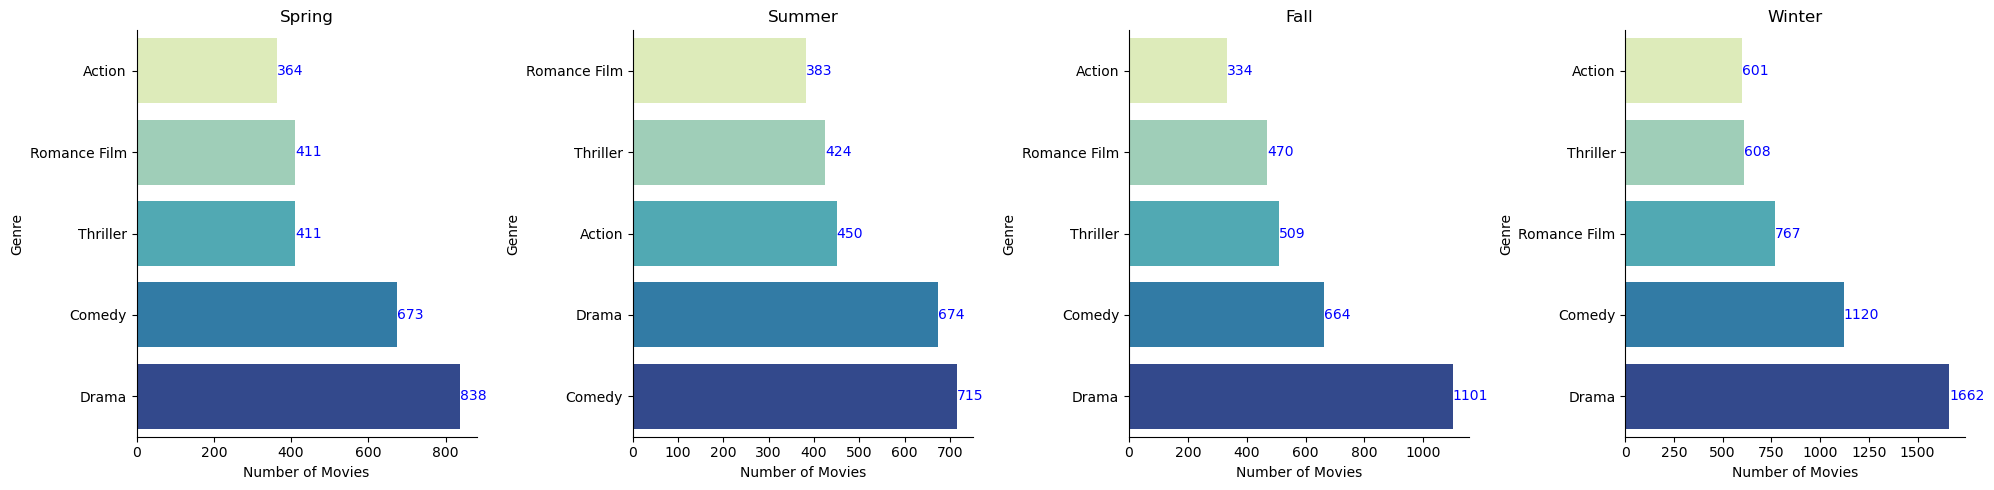

In [108]:
genre_season_count = df_genres.groupby(['season', 'movie_genres']).size().reset_index(name='movie_count')

# Number of top genres to display per season
top_n = 5  # Adjust this number as needed

# Dictionary to store top genres per season
top_genres_per_season = {}

for season in genre_season_count['season'].unique():
    top_genres = (
        genre_season_count[genre_season_count['season'] == season]
        .sort_values('movie_count', ascending=False)
        .head(top_n)['movie_genres']
        .tolist()
    )
    top_genres_per_season[season] = top_genres


# Initialize an empty DataFrame to store filtered data
filtered_genre_season_count = pd.DataFrame()

# Loop through each season and filter the top genres
for season in top_genres_per_season:
    top_genres = top_genres_per_season[season]
    temp_df = genre_season_count[
        (genre_season_count['season'] == season) &
        (genre_season_count['movie_genres'].isin(top_genres))
    ]
    filtered_genre_season_count = pd.concat([filtered_genre_season_count, temp_df], ignore_index=True)

# Rename columns for clarity
filtered_genre_season_count.rename(
    columns={
        'movie_genres': 'Genre',
        'movie_count': 'Movie Count',
        'season': 'Season'
    },
    inplace=True
)

# Set the order of seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Create the FacetGrid
g = sns.FacetGrid(
    filtered_genre_season_count,
    col="Season",
    col_order=season_order,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1
)

# Adjust y-ticks and plot data
for ax, season in zip(g.axes.flat, season_order):
    # Get data for the current season
    data = filtered_genre_season_count[filtered_genre_season_count['Season'] == season]
    # Get top genres and reverse for better visualization
    top_genres = list(reversed(top_genres_per_season.get(season, [])))
    # Sort data accordingly
    data = data.set_index('Genre').loc[top_genres].reset_index()
    # Plot
    sns.barplot(
        x='Movie Count',
        y='Genre',
        data=data,
        palette='YlGnBu',
        ax=ax
    )
    ax.set_title(season)
    ax.set_xlabel('Number of Movies')
    ax.set_ylabel('Genre')
    
    # Adjust y-ticks
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # Display values on bars
    for i, v in enumerate(data['Movie Count']):
        ax.text(v + 0.1, i, str(int(v)), color='blue', va='center')

plt.tight_layout()
plt.show()


Alternative representation

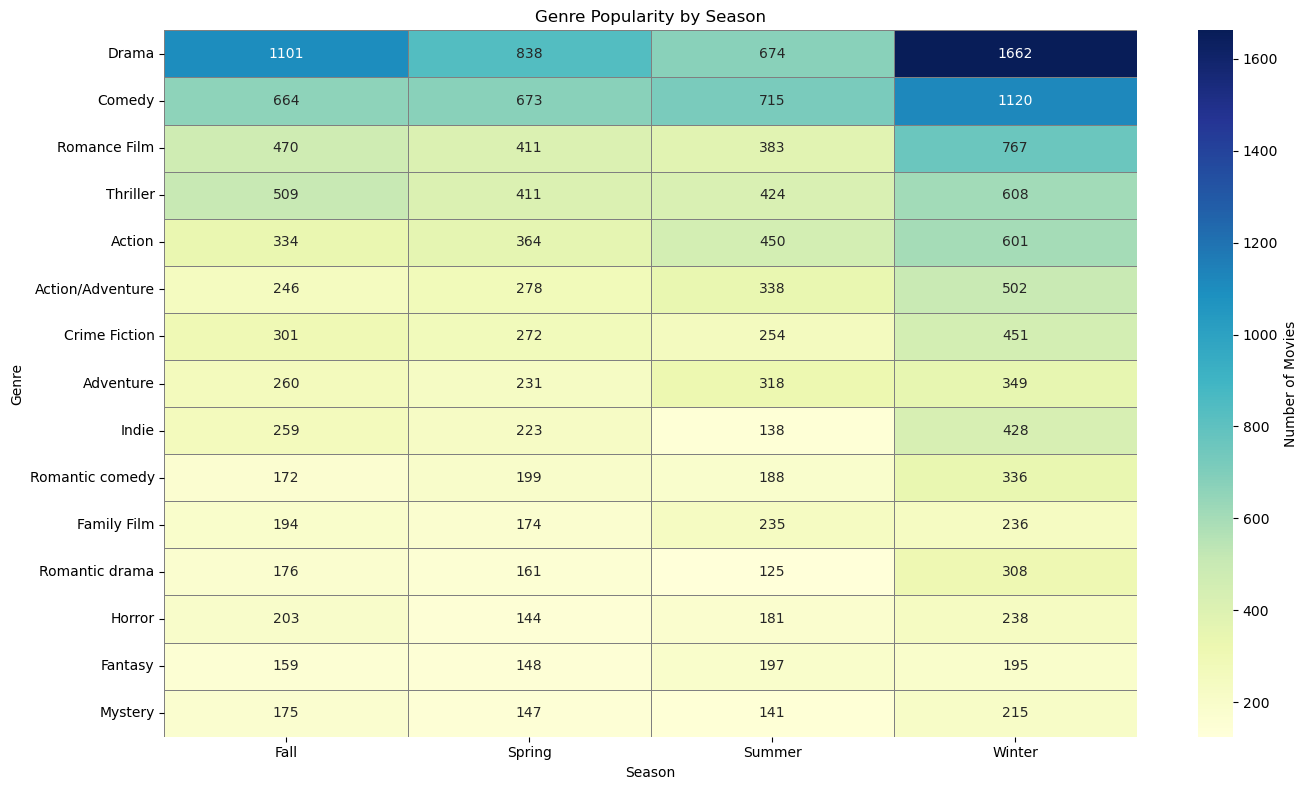

In [109]:
# Create pivot table
pivot_table = genre_season_count.pivot_table(
    values='movie_count',
    index='movie_genres',
    columns='season',
    aggfunc='sum',
    fill_value=0
)

# Select top genres overall
top_genres_overall = df_genres['movie_genres'].value_counts().head(15).index.tolist()
pivot_table = pivot_table.loc[top_genres_overall]

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt="d",
    cmap='YlGnBu',
    linewidths=.5,
    linecolor='gray',
    cbar_kws={'label': 'Number of Movies'}
)
plt.title('Genre Popularity by Season')
plt.xlabel('Season')
plt.ylabel('Genre')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



ANOVA for Seasons

In [110]:
import ast

# Convert the string representation to an actual list
df['movie_genres'] = df['movie_genres'].apply(ast.literal_eval)

# Extract genre names
df['movie_genres'] = df['movie_genres'].apply(lambda x: [genre[1] for genre in x])

# For simplicity, we'll focus on the primary genre (first in the list)
df['primary_genre'] = df['movie_genres'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

# Drop rows with missing primary genre
df = df.dropna(subset=['primary_genre'])


In [121]:
from scipy.stats import f_oneway

# Create a list of revenues for each season
season_revenues = [df[df['season'] == season]['movie_box_office_revenue'] for season in df['season'].unique()]

# Perform one-way ANOVA
F_statistic, p_value = f_oneway(*season_revenues)

print('ANOVA Results for Seasons:')
print('F-statistic:', F_statistic)
print('p-value:', p_value)



ANOVA Results for Seasons:
F-statistic: 58.03858867596025
p-value: 4.026993115304173e-37


With reduced complexity


ANOVA Results for Genres:
F-statistic: 26.905268692916312
p-value: 4.680119529464702e-22


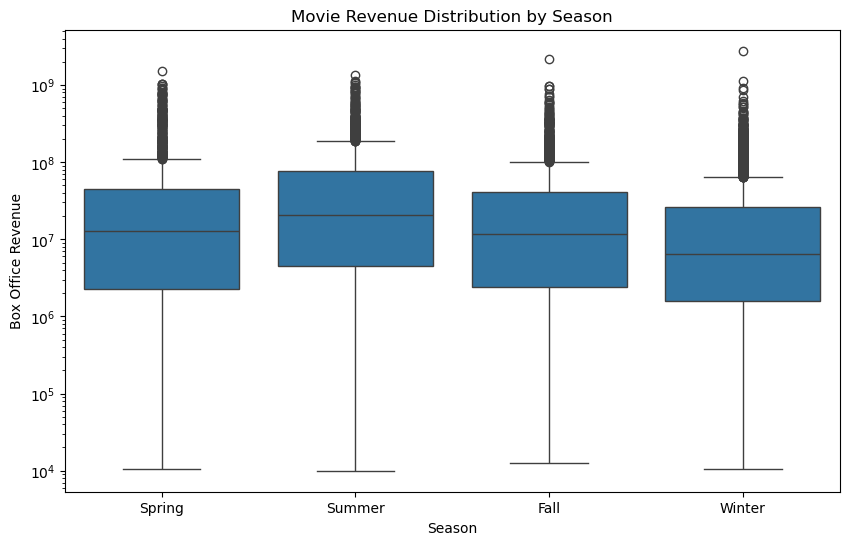

In [119]:
# Consider top N genres to reduce complexity
top_genres = df['primary_genre'].value_counts().head(5).index.tolist()
df_top_genres = df[df['primary_genre'].isin(top_genres)]

# Create a list of revenues for each genre
genre_revenues = [df_top_genres[df_top_genres['primary_genre'] == genre]['movie_box_office_revenue'] for genre in top_genres]

# Perform one-way ANOVA
F_statistic, p_value = f_oneway(*genre_revenues)

print('\nANOVA Results for Genres:')
print('F-statistic:', F_statistic)
print('p-value:', p_value)

plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='movie_box_office_revenue', data=df, order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Movie Revenue Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Box Office Revenue')
plt.yscale('log')  # Use log scale if the revenue distribution is highly skewed
plt.show()

Boxplot of Revenue by Season

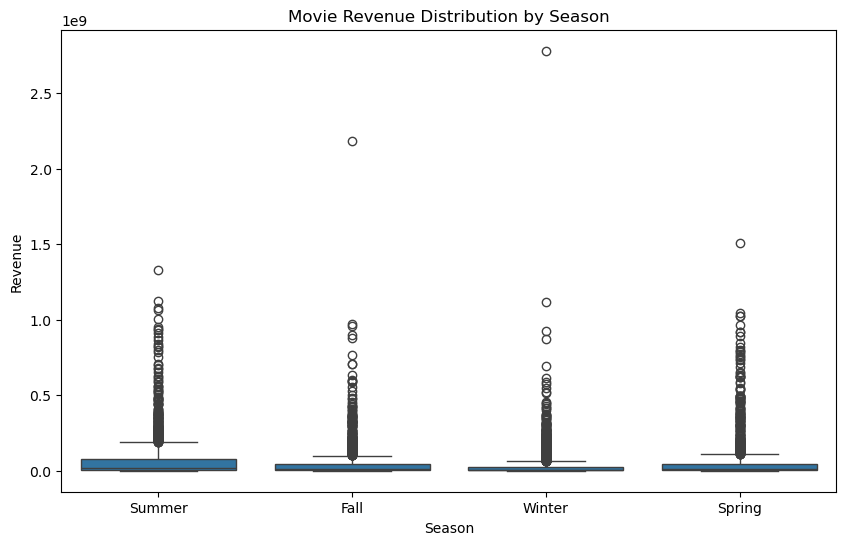

In [117]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='movie_box_office_revenue', data=df)
plt.title('Movie Revenue Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Revenue')
plt.show()


Boxplot of Revenue by Genre

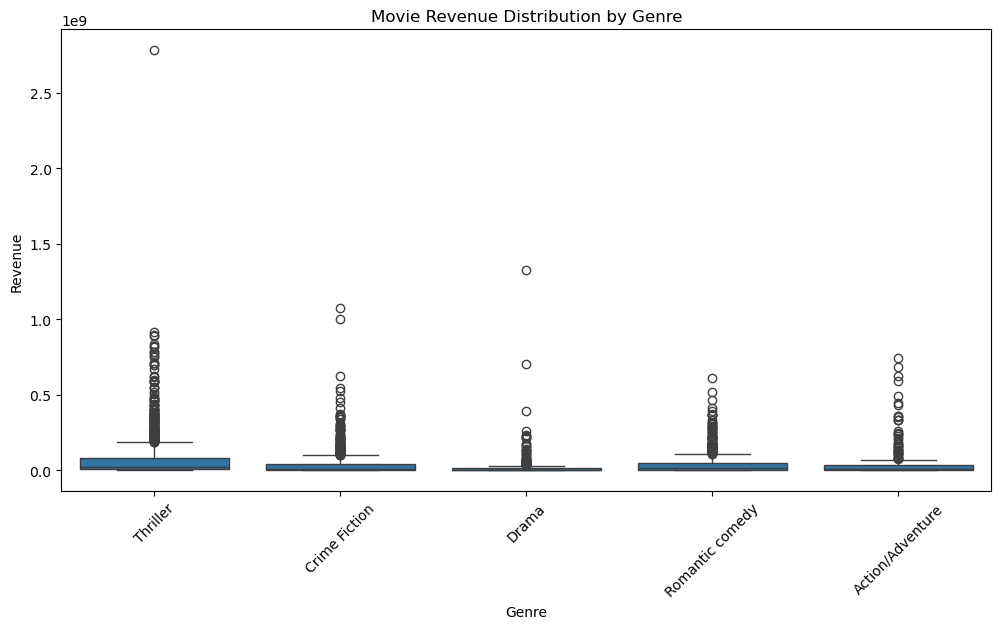

In [118]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='primary_genre', y='movie_box_office_revenue', data=df_top_genres)
plt.title('Movie Revenue Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()
